In [1]:
# preferred public surface
import os
import sys

sys.path.insert(0, os.path.abspath(".."))  # adds .../src to sys.path
from annnet.adapters.networkx_adapter import from_nx, to_backend, to_nx
from annnet.core import AnnNet

In [3]:
print("=== Basic graph creation ===")
G = AnnNet()
G.add_vertex("A", color="red", name="amine")
G.add_vertex("B")


eidx = G.add_edge({"A"}, {"B"})

eidx = G.add_edge("D", "C")

print("Vertices:", tuple(G.V))

print("Edges (index, (S,T)):", [(i, G.get_edge(i)) for i in range(G.num_edges)])
print("Number of vertices:", G.num_vertices)
print("Number of edges:", G.num_edges)
print("Shape (|V|,|E|):", G.shape)
print()

print("=== Accessing edge info ===")
S, T = G.get_edge(eidx)
print("Edge definition:", S, "->", T)
print()

print("=== Incidence matrix with per-vertex coefficients ===")
H = AnnNet()
H.add_vertices(["X", "Y"])

e2 = H.add_edge(
    "Xa", "Ya", edge_source_attr={"Xa": {"__value": 3}}, edge_target_attr={"Ya": {"__value": 2}}
)

e2 = H.add_edge("X", "Y")
attrs = H.get_edge_attrs(e2)
src_map = dict(attrs.get("__source_attr", {}))
tgt_map = dict(attrs.get("__target_attr", {}))
src_map["X"] = {"__value": 3}
tgt_map["Y"] = {"__value": 2}
H.set_edge_attrs(e2, __source_attr=src_map, __target_attr=tgt_map)

mat = H.vertex_incidence_matrix(values=True, sparse=False)
print("Vertices:", tuple(H.V))
print("Incidence matrix:\n", mat)
print()

print("=== Subgraph ===")
SG = G.edge_subgraph([eidx])  # keep only that edge
print("Edge-subgraph edges:", [(i, SG.get_edge(i)) for i in range(SG.num_edges)])
print()

print("=== Prune (if available) ===")
if hasattr(G, "prune"):
    P = G.prune(source=["A"], target=["C"])
    print("Pruned graph edges:", [(i, P.get_edge(i)) for i in range(P.num_edges)])
else:
    print("G.prune not implemented; skipping.")
print()

print("=== slices and per-slice weights ===")
D = AnnNet()
D.add_vertex("A")
D.add_vertex("B")
D.add_slice("t0")

e = D.add_edge("A", "B", weight=1.5, label="ab")
eid = D.idx_to_edge[e] if isinstance(e, int) else e

# Attach same edge to slice (preserve stable eid), set per-slice weight
w = D.edge_weights.get(eid, None)
D.add_edge("A", "B", slice="t0", edge_id=eid, edge_directed=True, weight=w)
D.set_slice_edge_weight("t0", eid, 2.0)

print("Edge definitions:", list(D.edge_definitions.items()))
print("Global edge weight:", D.edge_weights.get(eid))
print("slice t0 weight:", D.get_effective_edge_weight(eid, slice="t0"))
print("slices containing edge:", D.edge_presence_across_slices(eid, include_default=True))

=== Basic graph creation ===
Vertices: ('A', 'B', 'D', 'C')
Edges (index, (S,T)): [(0, (frozenset({'A'}), frozenset({'B'}))), (1, (frozenset({'D'}), frozenset({'C'})))]
Number of vertices: 4
Number of edges: 2
Shape (|V|,|E|): (4, 2)

=== Accessing edge info ===
Edge definition: frozenset({'D'}) -> frozenset({'C'})

=== Incidence matrix with per-vertex coefficients ===
Vertices: ('X', 'Y', 'Xa', 'Ya')
Incidence matrix:
 [[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

=== Subgraph ===
Edge-subgraph edges: [(0, (frozenset({'D'}), frozenset({'C'})))]

=== Prune (if available) ===
G.prune not implemented; skipping.

=== slices and per-slice weights ===
Edge definitions: [('edge_0', ('A', 'B', 'regular'))]
Global edge weight: 1.5
slice t0 weight: 2.0
slices con

Nodes: [('A', {'color': 'red', 'name': 'amine'}), ('B', {'color': None, 'name': None}), ('D', {'color': None, 'name': None}), ('C', {'color': None, 'name': None})]
Edges: [('A', 'B', {'__weight': 1.0}), ('D', 'C', {'__weight': 1.0})]


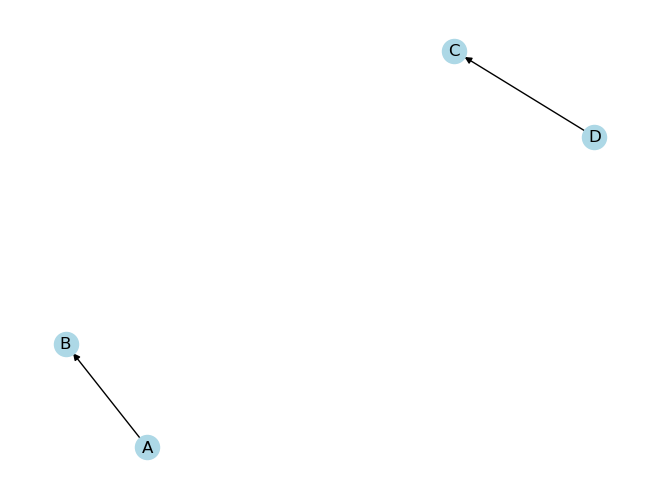

In [5]:
# convert to a networkx graph
import networkx as nx

nxG = to_backend(G, directed=True)  # or directed=False if you prefer

print("Nodes:", nxG.nodes(data=True))
print("Edges:", nxG.edges(data=True))

# quick visualization
import matplotlib.pyplot as plt

pos = nx.spring_layout(nxG)
nx.draw(nxG, pos, with_labels=True, node_color="lightblue")
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, "weight"))
plt.show()

In [7]:
nxG, man = to_nx(G, directed=True, hyperedge_mode="skip")

In [9]:
H2 = from_nx(nxG, man)
print(list(H2.edges()))

['edge_0', 'edge_1']


In [11]:
for eid in H2.edges():  # eid is a string
    eidx = H2.edge_to_idx[eid]  # index (int), if you need it
    S, T = H2.get_edge(eid)  # make sure get_edge accepts id OR index
    attrs = H2.get_edge_attrs(eid)  # <-- use the dict getter you added
    print(eid, S, T, attrs)

edge_0 frozenset({'A'}) frozenset({'B'}) {}
edge_1 frozenset({'C'}) frozenset({'D'}) {}


In [13]:
print(H2.vertex_attributes.head())  # attrs present
print(H2.edge_attributes.head())  # attrs present

shape: (4, 3)
┌───────────┬───────┬───────┐
│ vertex_id ┆ color ┆ name  │
│ ---       ┆ ---   ┆ ---   │
│ str       ┆ str   ┆ str   │
╞═══════════╪═══════╪═══════╡
│ A         ┆ red   ┆ amine │
│ B         ┆ null  ┆ null  │
│ D         ┆ null  ┆ null  │
│ C         ┆ null  ┆ null  │
└───────────┴───────┴───────┘
shape: (0, 1)
┌─────────┐
│ edge_id │
│ ---     │
│ str     │
╞═════════╡
└─────────┘


In [15]:
G.vertex_attributes.head()

vertex_id,color,name
str,str,str
"""A""","""red""","""amine"""
"""B""",null,null
"""D""",null,null
"""C""",null,null


g

In [18]:
from annnet.adapters.igraph_adapter import from_igraph, to_igraph

In [20]:
igG, manifest = to_igraph(G, directed=True, hyperedge_mode="skip", public_only=False)
H = from_igraph(igG, manifest)
H

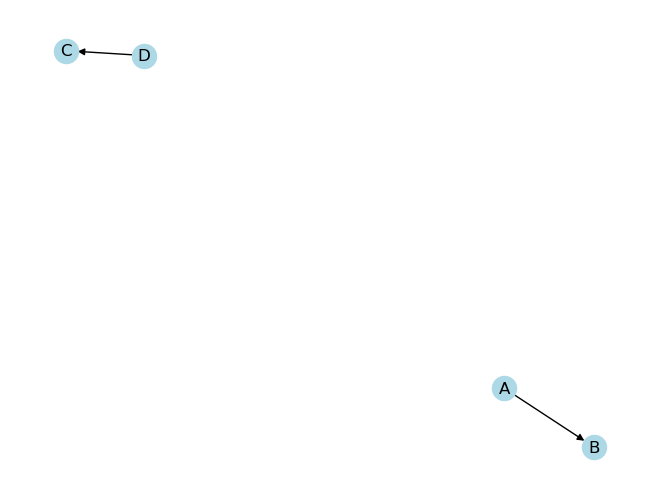

In [22]:
nxG, _ = to_nx(G, directed=True, hyperedge_mode="skip")

pos = nx.spring_layout(nxG)
nx.draw(nxG, pos, with_labels=True, node_color="lightblue")
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, "weight"))
plt.show()

In [24]:
from IPython.display import SVG, display

from annnet.utils.plotting import plot

obj = plot(
    G,
    backend="graphviz",
    layout="dot",
    use_weight_style=False,
    show_edge_labels=True,
    **{
        "graph_attr": {"bgcolor": "white"},
        "node_attr": {"shape": "circle", "fixedsize": "true"},
        "edge_attr": {"color": "black", "penwidth": "3.0"},
    },
)

svg_data = obj.pipe(format="svg").decode("utf-8")
display(SVG(svg_data))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH